# Testing models

In [2]:
# import pandas & numpy library
import pandas as pd
import numpy as np

# imoprt seaborn & matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# import KNN from sklearn
from sklearn.neighbors import KDTree

# shows a bigger plot size for readability 
plt.rcParams['figure.figsize'] = (12, 5)
#improve resolution
%config InlineBackend.figure_format ='retina'


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score, confusion_matrix

In [16]:
# read 'songDb.tsv' into dataframe with correct encoding  
music = pd.read_csv('songDb.tsv', sep='\t', encoding='ISO-8859-1')

C:\Users\David Soberanis\AppData\Local\Temp\ipykernel_10216\3079004086.py:2: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  music = pd.read_csv('songDb.tsv', sep='\t', encoding='ISO-8859-1')


# Cleaning and Filtering rows
- gets rid of NaN values
- removes all songs that are not in the top 5 genres
- fixes indexing 
- fixes dtypes

In [17]:
df = music # for testing

df = df.rename({'Genre':'genres'}, axis='columns') # rename to match 
df = df.dropna()

# combines subgenres into more general Genres. This function removes all genres outside of the top 5.
# You can alter this to include more than the top 5 genres
def CombineGenre(str_in):

    try:
        str_in = str_in.lower()
        str_in = str_in.strip()
        
        if 'rock' in str_in or 'prog' in str_in or 'gaze' in str_in or 'psych' in str_in:
            output = 'Rock'
        elif 'hip hop' in str_in or 'rap' in str_in or 'grime' in str_in or 'trap' in str_in:
            output = 'Rap'
        elif 'pop' in str_in:
            output = 'Pop'
        elif ('edm' in str_in or 'electronic' in str_in or 'house' in str_in or 'industrial' in str_in or 'glitch' in str_in 
                or 'idm' in str_in or 'techno' in str_in or 'garage' in str_in or 'reggeaton' in str_in or 'synth' in str_in 
                or 'dubstep' in str_in or 'trance' in str_in or 'wave' in str_in or 'electro' in str_in):
            output = 'Electronic'
        elif 'indie' in str_in:
            output = 'Indie'
        else:
            output  = np.nan
    except:
        output = np.nan
        
    return output

# applys above function to combine genres
df['genres'] = df['genres'].apply(CombineGenre)
df = df.dropna() # removes all genres that were not combined before 
df = df.reset_index() # resets the index since we removed many rows
# df # shows now filtered df of music
# df['genres'].value_counts() # shows number of songs in each top 5 genres


In [18]:
feature_cols = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode',
                'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence',
                'Tempo', 'Duration_ms', 'time_signature']

df[feature_cols] = df[feature_cols].astype(np.float64)

# Create Design Matrix and Target vectors from the now filtered Df 

In [19]:
# Start by removing all columns that are not features 

feature_cols = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode',
                'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence',
                'Tempo', 'Duration_ms', 'time_signature']
target_col = 'genres'

X = df[feature_cols]
y = df[target_col]

print(f'Feature cols: {feature_cols}')
print(f'Target: {target_col}')

Feature cols: ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'time_signature']
Target: genres


### Train Test Split

In [20]:
# Create train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.7, random_state=42)

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (15588, 13)
Testing shape: (36374, 13)


# Model Tests

### kNN test

In [ ]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

# Label encoder for target (fitting it now to avoid unknown classes or different labels in testing)
le = LabelEncoder().fit(df[target_col].unique())

# KNN transformer and classifier
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3, n_jobs = -1)

# Pipelining
nca_pipe = Pipeline([
    ('nca', nca), 
    ('knn', knn)
])

# Fit
nca_pipe.fit(X_train, le.transform(y_train))

# Preliminary score
print(nca_pipe.score(X_test, le.transform(y_test)))

### SVM

In [ ]:
# SVM code
# from sklearn.svm import SVC # "Support vector classifier"
# model = SVC(kernel='linear', C=1)
# model.fit(X, y)

In [ ]:
# model.score(X,y)

0.35460528848004313

In [ ]:
#from sklearn.model_selection import cross_val_score
#cross_score = cross_val_score(model, X, y, cv=5)

In [ ]:
#cross_score

array([0.36255172, 0.33407101, 0.35459969, 0.34853734, 0.36046959])

### Logistic Regression

In [3]:
# Read in the different PCAs as dataframes for testing


X_train_08 = pd.read_csv('X_train_0.8.csv')
X_train_09 = pd.read_csv('X_train_0.9.csv')
X_train_095 = pd.read_csv('X_train_0.95.csv')

X_test_08 = pd.read_csv('X_test_0.8.csv')
X_test_09 = pd.read_csv('X_test_0.9.csv')
X_test_095 = pd.read_csv('X_test_0.95.csv')

X_PCA = [X_train_08, X_train_09, X_train_095, X_test_08, X_test_09, X_test_095]

y_train_PCA = pd.read_csv('Y_train.csv')
y_test_PCA = pd.read_csv('Y_test.csv')

y_PCA = [y_train_PCA, y_test_PCA]

# Dimensions for all of these splits
for i in X_PCA:
    print(i.shape)
print(' ')
for i in y_PCA:
    print(i.shape)

(41569, 6)
(41569, 7)
(41569, 9)
(10393, 6)
(10393, 7)
(10393, 9)
 
(41569, 2)
(10393, 2)


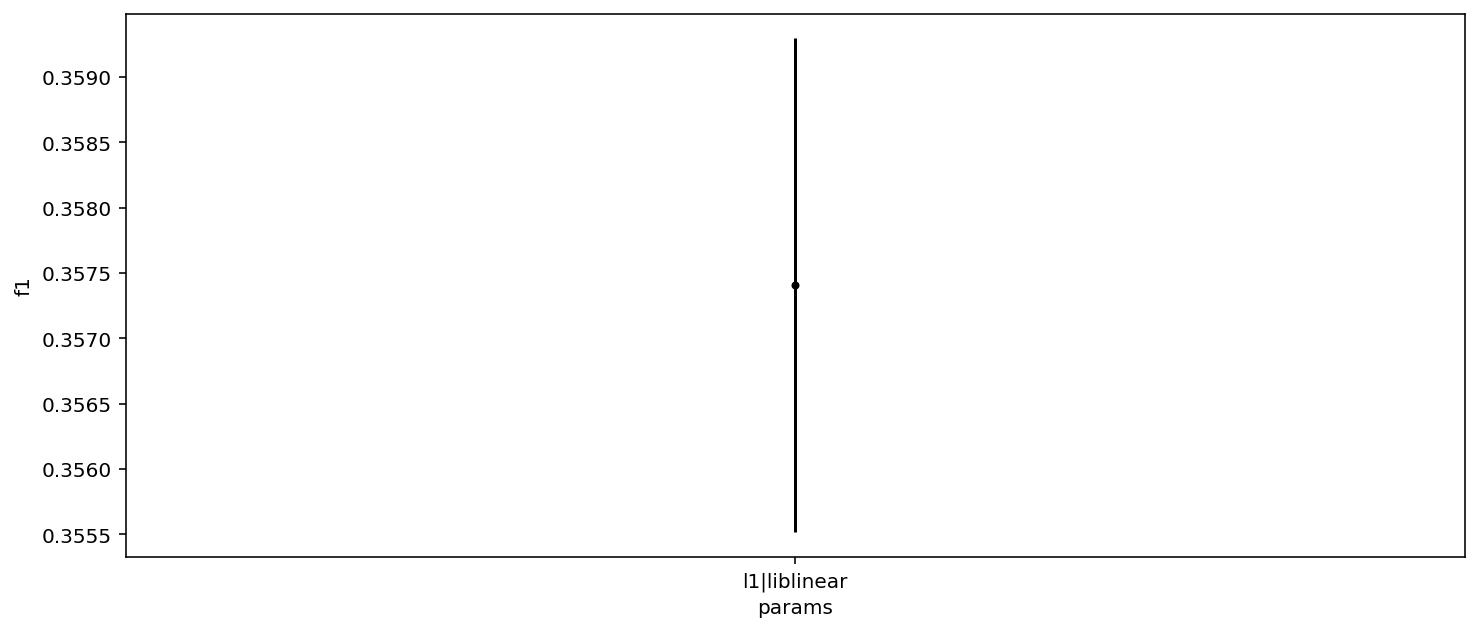

In [10]:


def plot_results(gridsearchcv):
    params = gridsearchcv.cv_results_["params"]
    ys = gridsearchcv.cv_results_["mean_test_score"]
    xs = ['|'.join(str(v) for v in param.values()) for param in params]
    yerr = gridsearchcv.cv_results_["std_test_score"]
    plt.errorbar(xs, ys, yerr / np.sqrt(gridsearchcv.cv), fmt='.k')
    plt.ylabel("f1")
    plt.xlabel("params")
    
def check_for_convergence(gridsearchcv):
    return gridsearchcv.best_estimator_.steps[-1][1].n_iter_ < gridsearchcv.best_estimator_.steps[-1][1].max_iter


np.random.seed(31415) 

scaler = StandardScaler()
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
logistic = LogisticRegression() # first step

# YOUR CODE HERE

pipe = Pipeline(steps=[("scaler", scaler), ("imputer", imp), ("logistic", logistic)])

# you don't need to modify the max_iter param. If you do, keep it under 1000
# hint, prefix your param names with logistic__ to pass it to the logistic step

# this grid when passed to the gridsearch will make a logistic regression 
# if you add more to the param_grid you can compare differnt models and see their IQR
param_grid = { 
    "logistic__solver" : ['liblinear'], # use one algo from here it needs to be l1 https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
    "logistic__penalty" : ['l1'] # TA recommends using the l1 penalty 
}

# YOUR CODE HERE

# use f1_micro for scoring
# use 7 folds
gscv = GridSearchCV(pipe, param_grid, scoring = 'f1_micro', cv=7) # GridSearchCV(...)

# YOUR CODE HERE


# gscv.fit(X_train, y_train)
gscv.fit(X_train_08, y_train_PCA['genres'])

plot_results(gscv)


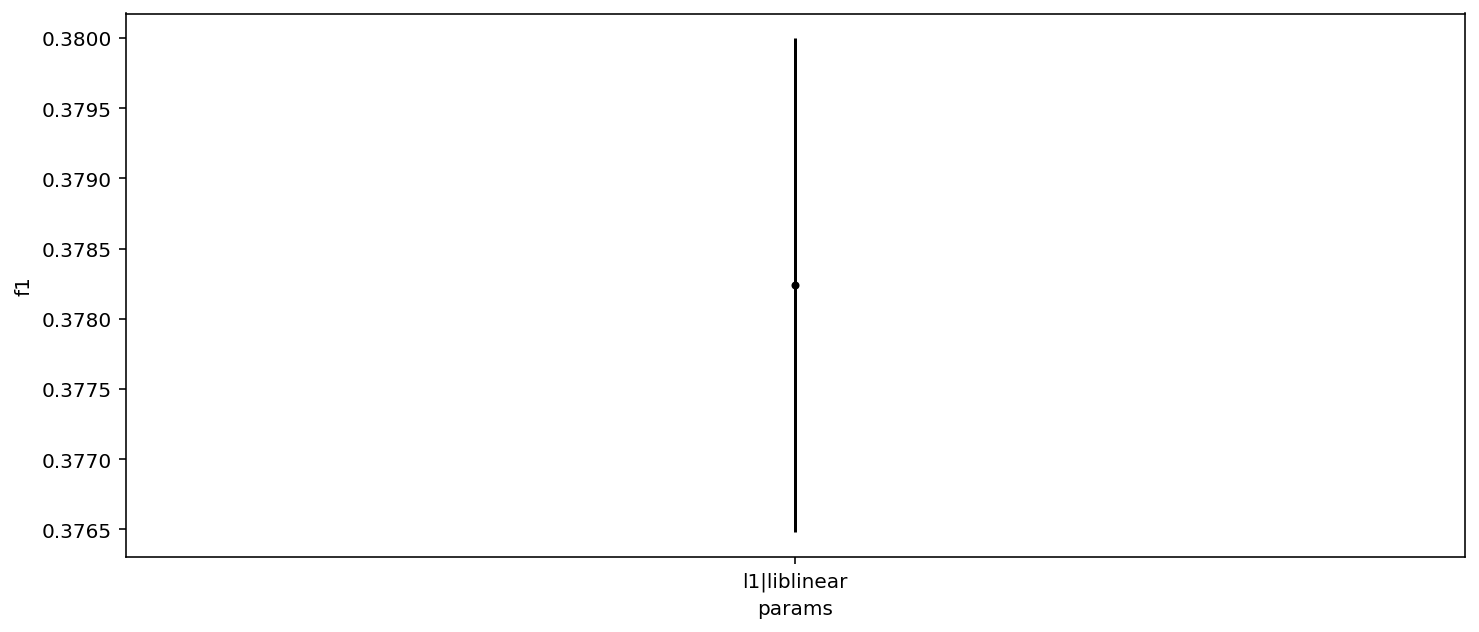

In [12]:
gscv.fit(X_train_09, y_train_PCA['genres'])
plot_results(gscv)

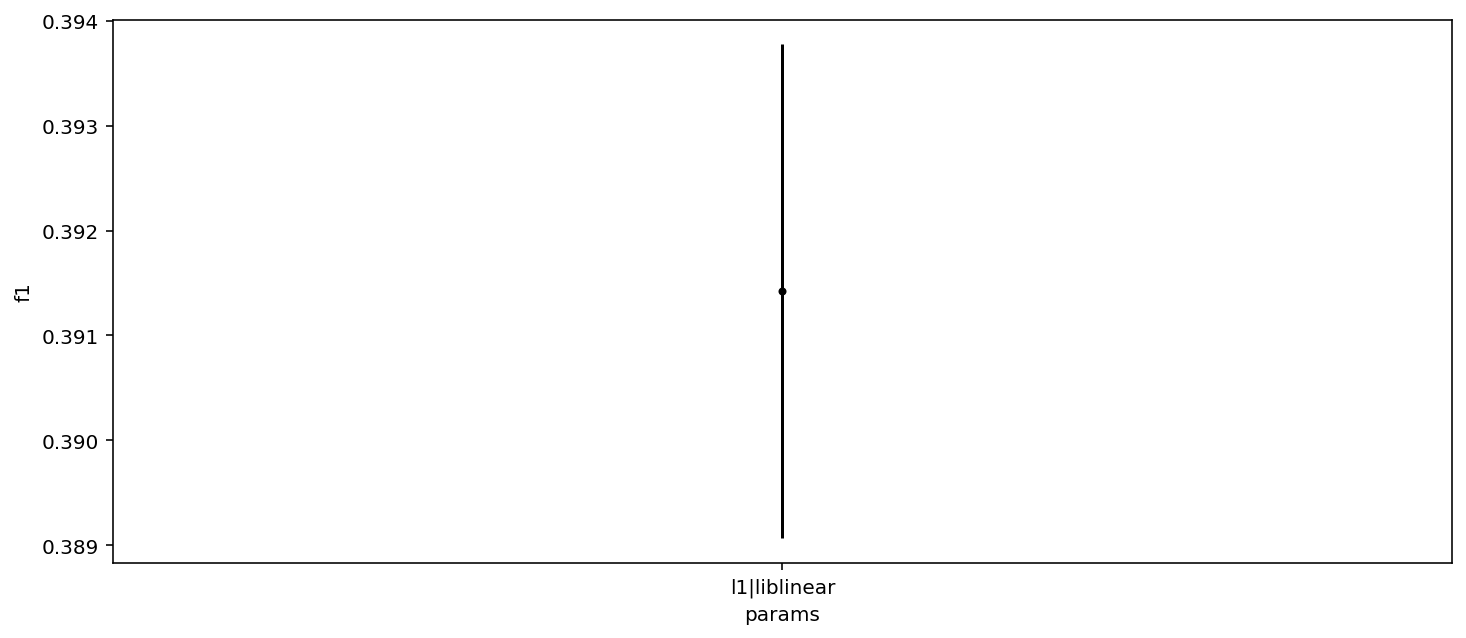

In [13]:
gscv.fit(X_train_095, y_train_PCA['genres'])
plot_results(gscv)

# LogReg with nonPCA data

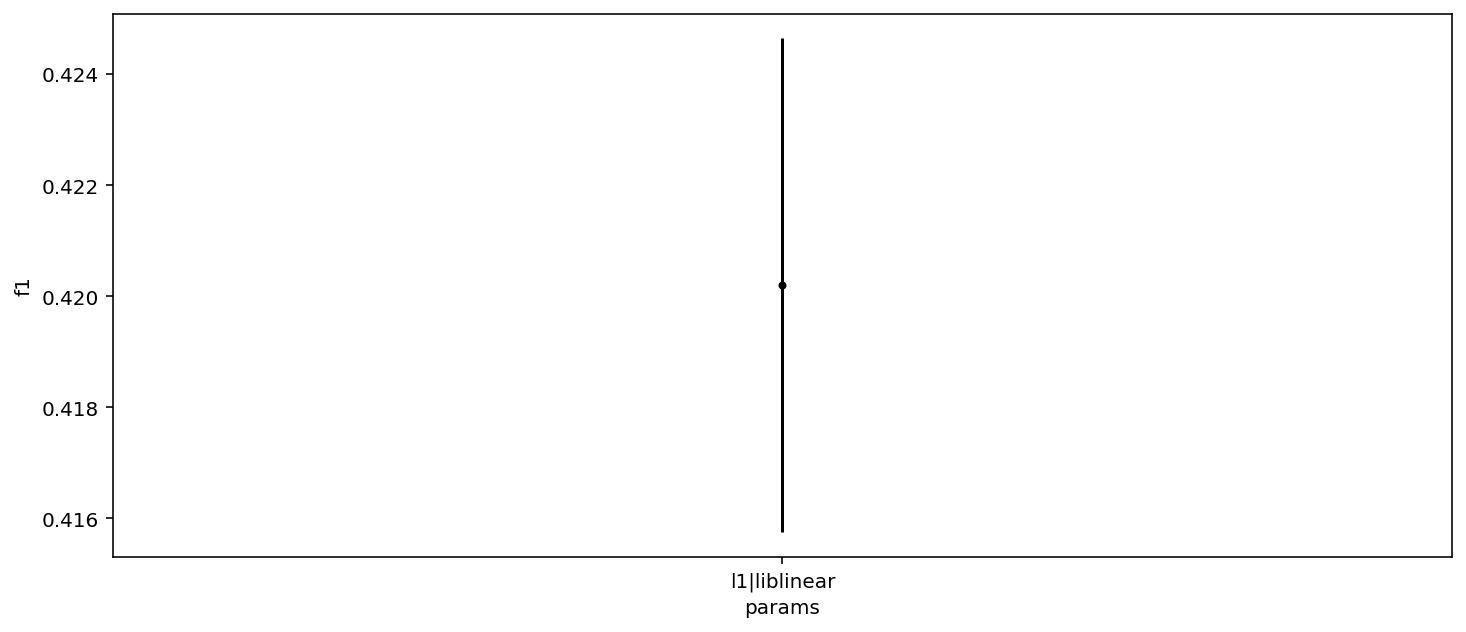

In [21]:
gscv.fit(X_train, y_train)
plot_results(gscv)